In [6]:
import matplotlib.pyplot as plt

from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing
from river import synth
from river import tree

In [7]:
dataset = datasets.Phishing()
dataset

Phishing websites.

This dataset contains features from web pages that are classified as phishing or not.

    Name  Phishing                                                                                      
    Task  Binary classification                                                                         
 Samples  1,250                                                                                         
Features  9                                                                                             
  Sparse  False                                                                                         
    Path  /home/giodefa/miniconda3/envs/river/lib/python3.9/site-packages/river/datasets/phishing.csv.gz

In [10]:
%%time

model = tree.HoeffdingTreeClassifier(grace_period=50)

for x,y in dataset:
    model.learn_one(x, y )

model

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 107 ms


HoeffdingTreeClassifier (
  grace_period=50
  max_depth=inf
  split_criterion="info_gain"
  split_confidence=1e-07
  tie_threshold=0.05
  leaf_prediction="nba"
  nb_threshold=0
  nominal_attributes=None
  splitter=GaussianSplitter (
    n_splits=10
  )
  binary_split=False
  max_size=100
  memory_estimate_period=1000000
  stop_mem_management=False
  remove_poor_attrs=False
  merit_preprune=True
)

In [12]:
model.summary
# abbiamo informazioni inerenti al nostro albero decisionale, quindi possiamo sicuramente avere informazioni!

{'n_nodes': 5,
 'n_branches': 2,
 'n_leaves': 3,
 'n_active_leaves': 3,
 'n_inactive_leaves': 0,
 'height': 3,
 'total_observed_weight': 1250.0}

In [13]:
model.to_dataframe()
# qui possiamo vedere più precisamente le informazioni stesse, cioè quando c'è lo split ecc

,parent,is_leaf,depth,stats,feature,threshold,splitter,splitters,_disabled_attrs,_last_split_attempt_at,_mc_correct_weight,_nb_correct_weight
node,,,,,,,,,,,,
0,<NA>,False,0,"{True: 260.0, False: 390.0}",empty_server_form_handler,0.545455,NaN,NaN,NaN,NaN,NaN,NaN
1,0,True,1,"{True: 443.4163997711022, False: 59.8769131081...",NaN,NaN,GaussianSplitter,{'empty_server_form_handler': GaussianSplitter...,{},474.293313,249.0,248.0
2,0,False,1,"{True: 71.58360022889778, False: 404.123086891...",popup_window,0.090909,NaN,NaN,NaN,NaN,NaN,NaN
3,2,True,2,"{False: 31.426538522574834, True: 33.0}",NaN,NaN,GaussianSplitter,{'empty_server_form_handler': GaussianSplitter...,{},59.426539,23.0,36.0
4,2,True,2,"{False: 250.57346147742516, True: 6.0}",NaN,NaN,GaussianSplitter,{'empty_server_form_handler': GaussianSplitter...,{},241.573461,210.0,196.0


In [28]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [41]:
from graphviz import Digraph

In [39]:
model.draw()

NameError: name 'graphviz' is not defined

In [42]:
x, y = next(iter(dataset))
x, y 

({'empty_server_form_handler': 0.0,
  'popup_window': 0.0,
  'https': 0.0,
  'request_from_other_domain': 0.0,
  'anchor_from_other_domain': 0.0,
  'is_popular': 0.5,
  'long_url': 1.0,
  'age_of_domain': 1,
  'ip_in_url': 1},
 True)

In [43]:
print(model.debug_one(x))

empty_server_form_handler ≤ 0.5454545454545454
Class True:
	P(False) = 0.1
	P(True) = 0.9



In [44]:
def friedman_track(n_samples=10_000):
    dataset = synth.Friedman(seed=42).take(n_samples)
    track = evaluate.Track("10K Friedman + MAE", dataset, metrics.MAE(), n_samples)

    return track

In [45]:
def plot_track(track, metric_name, models, n_samples, n_checkpoints):
    fig, ax = plt.subplots(figsize=(5, 5), nrows=3, dpi=300)
    for model_name, model in models.items():
        step = []
        error = []
        r_time = []
        memory = []

        for checkpoint in track(n_samples).run(model, n_checkpoints):
            step.append(checkpoint["Step"])
            error.append(checkpoint[metric_name])

            # Convert timedelta object into seconds
            r_time.append(checkpoint["Time"].total_seconds())
            # Make sure the memory measurements are in MB
            raw_memory, unit = float(checkpoint["Memory"][:-3]), checkpoint["Memory"][-2:]
            memory.append(raw_memory * 2**-10 if unit == 'KB' else raw_memory)

        ax[0].grid(True)
        ax[1].grid(True)
        ax[2].grid(True)

        ax[0].plot(step, error, label=model_name)
        ax[0].set_ylabel(metric_name)

        ax[1].plot(step, r_time, label=model_name)
        ax[1].set_ylabel('Time (seconds)')

        ax[2].plot(step, memory, label=model_name)
        ax[2].set_ylabel('Memory (MB)')
        ax[2].set_xlabel('Instances')

    plt.legend()
    plt.tight_layout()
    plt.close()

    return fig

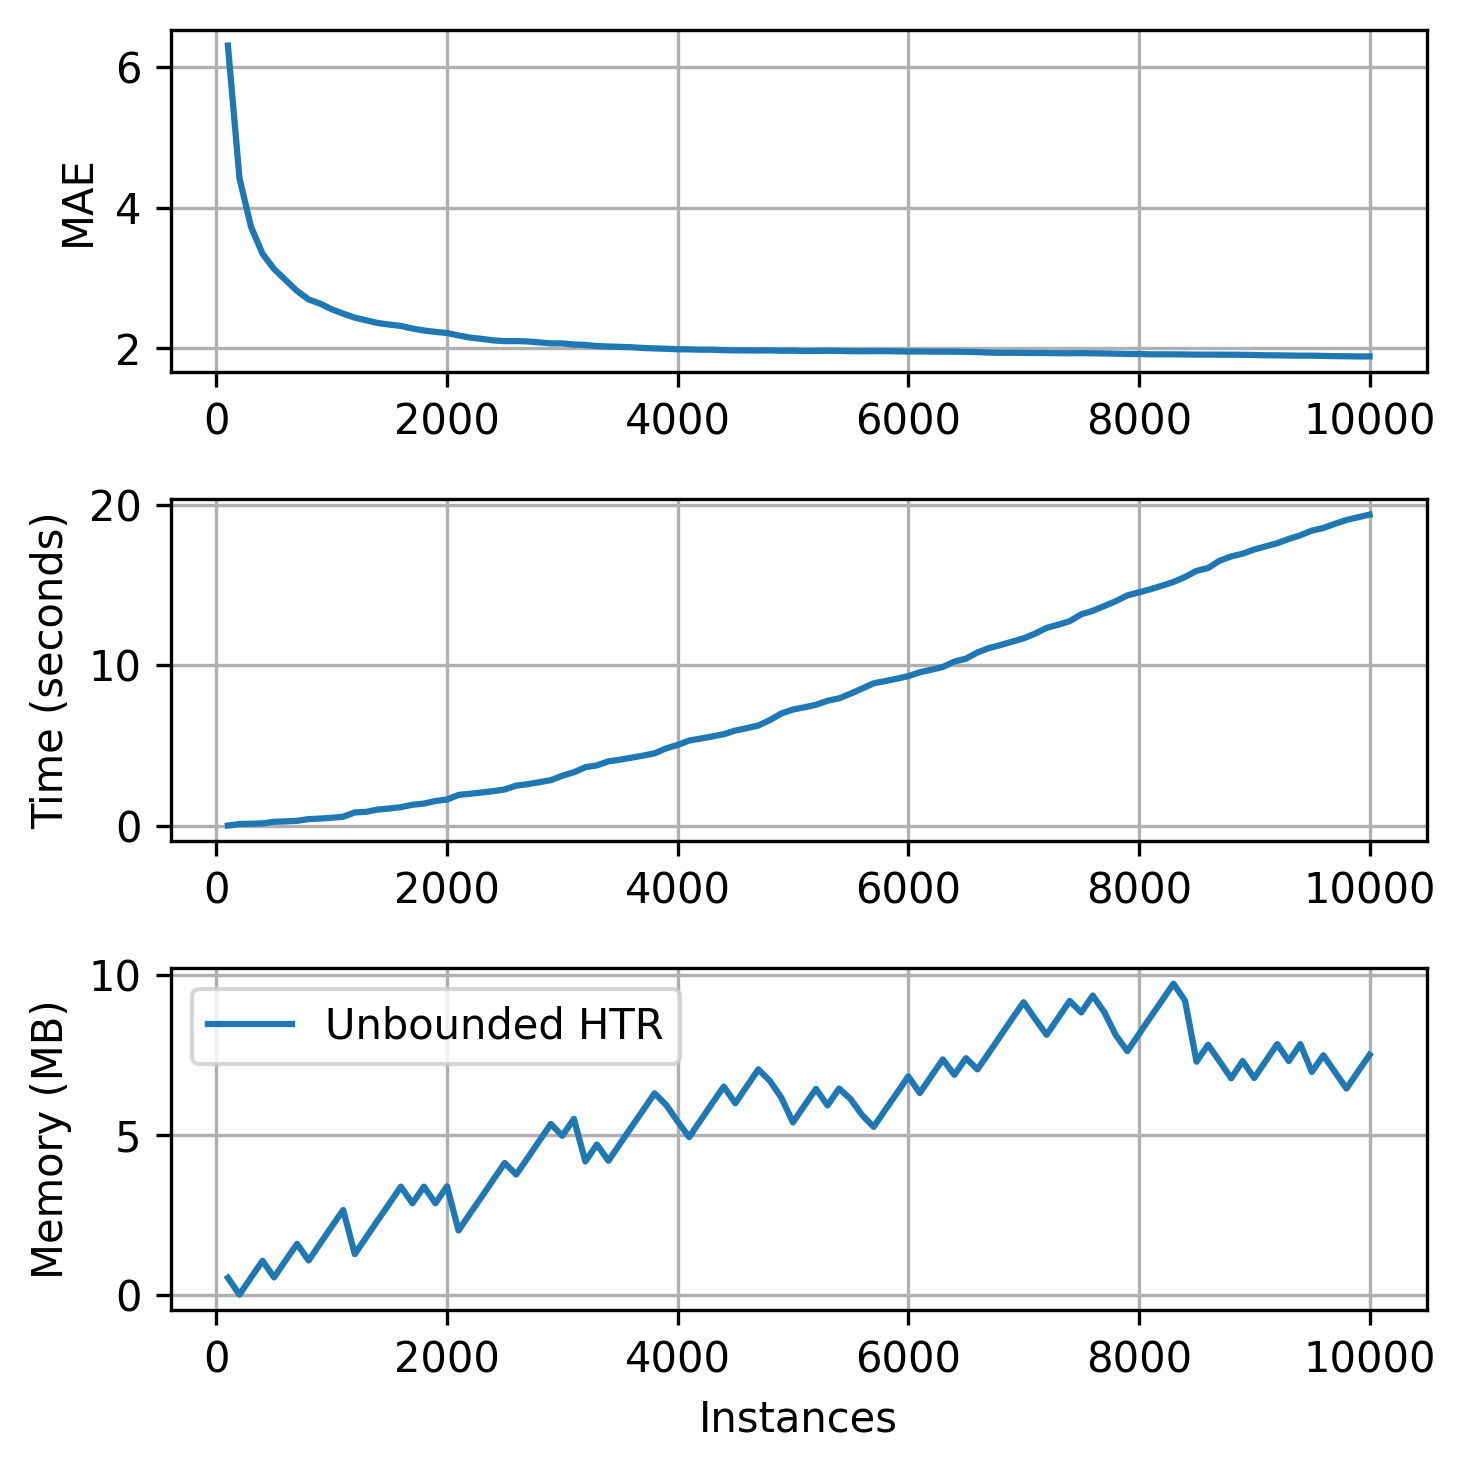

In [46]:
plot_track(
    friedman_track,
    "MAE",
    {"Unbounded HTR": (preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor())},
    10_000,
    100
)

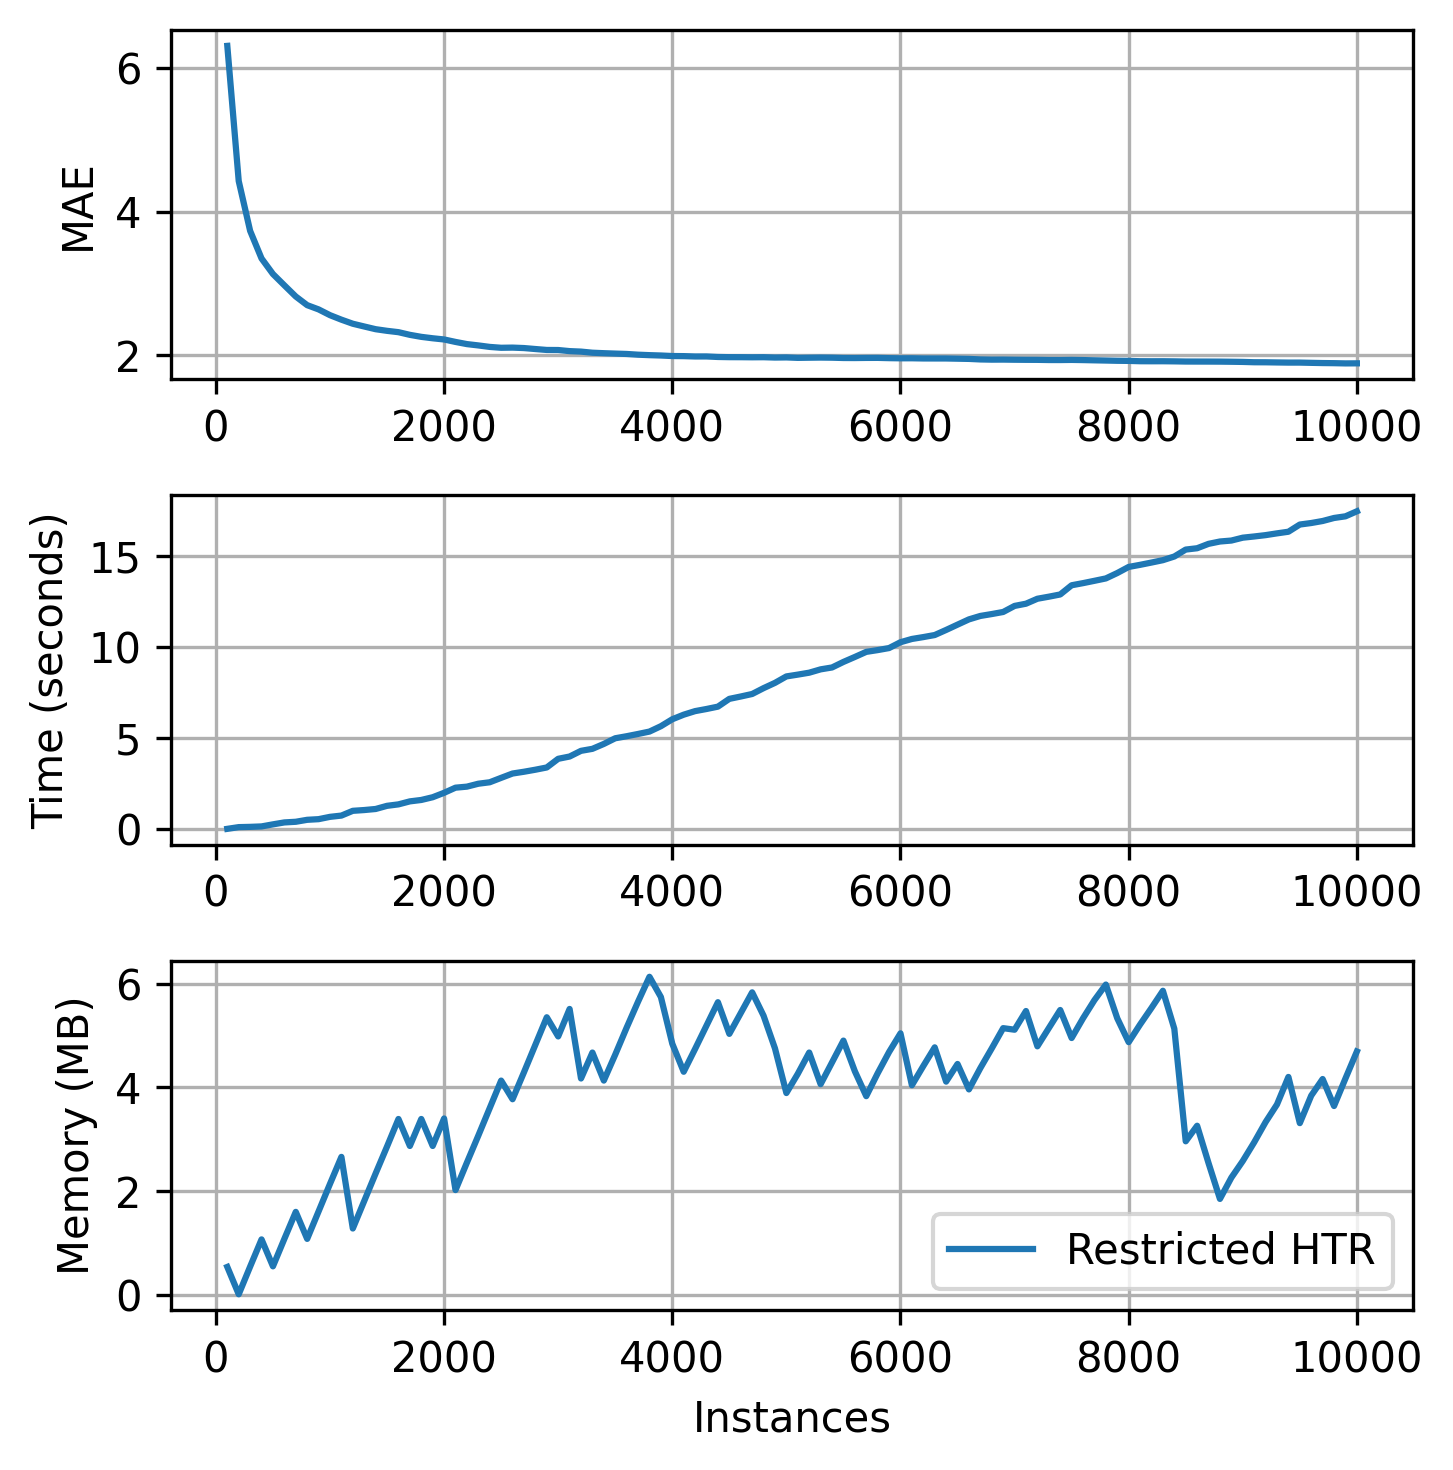

In [47]:
plot_track(
    friedman_track,
    "MAE",
    {
        "Restricted HTR": (
            preprocessing.StandardScaler()
            | tree.HoeffdingTreeRegressor(max_size=5, memory_estimate_period=500)
        )
    },
    10_000,
    100
)

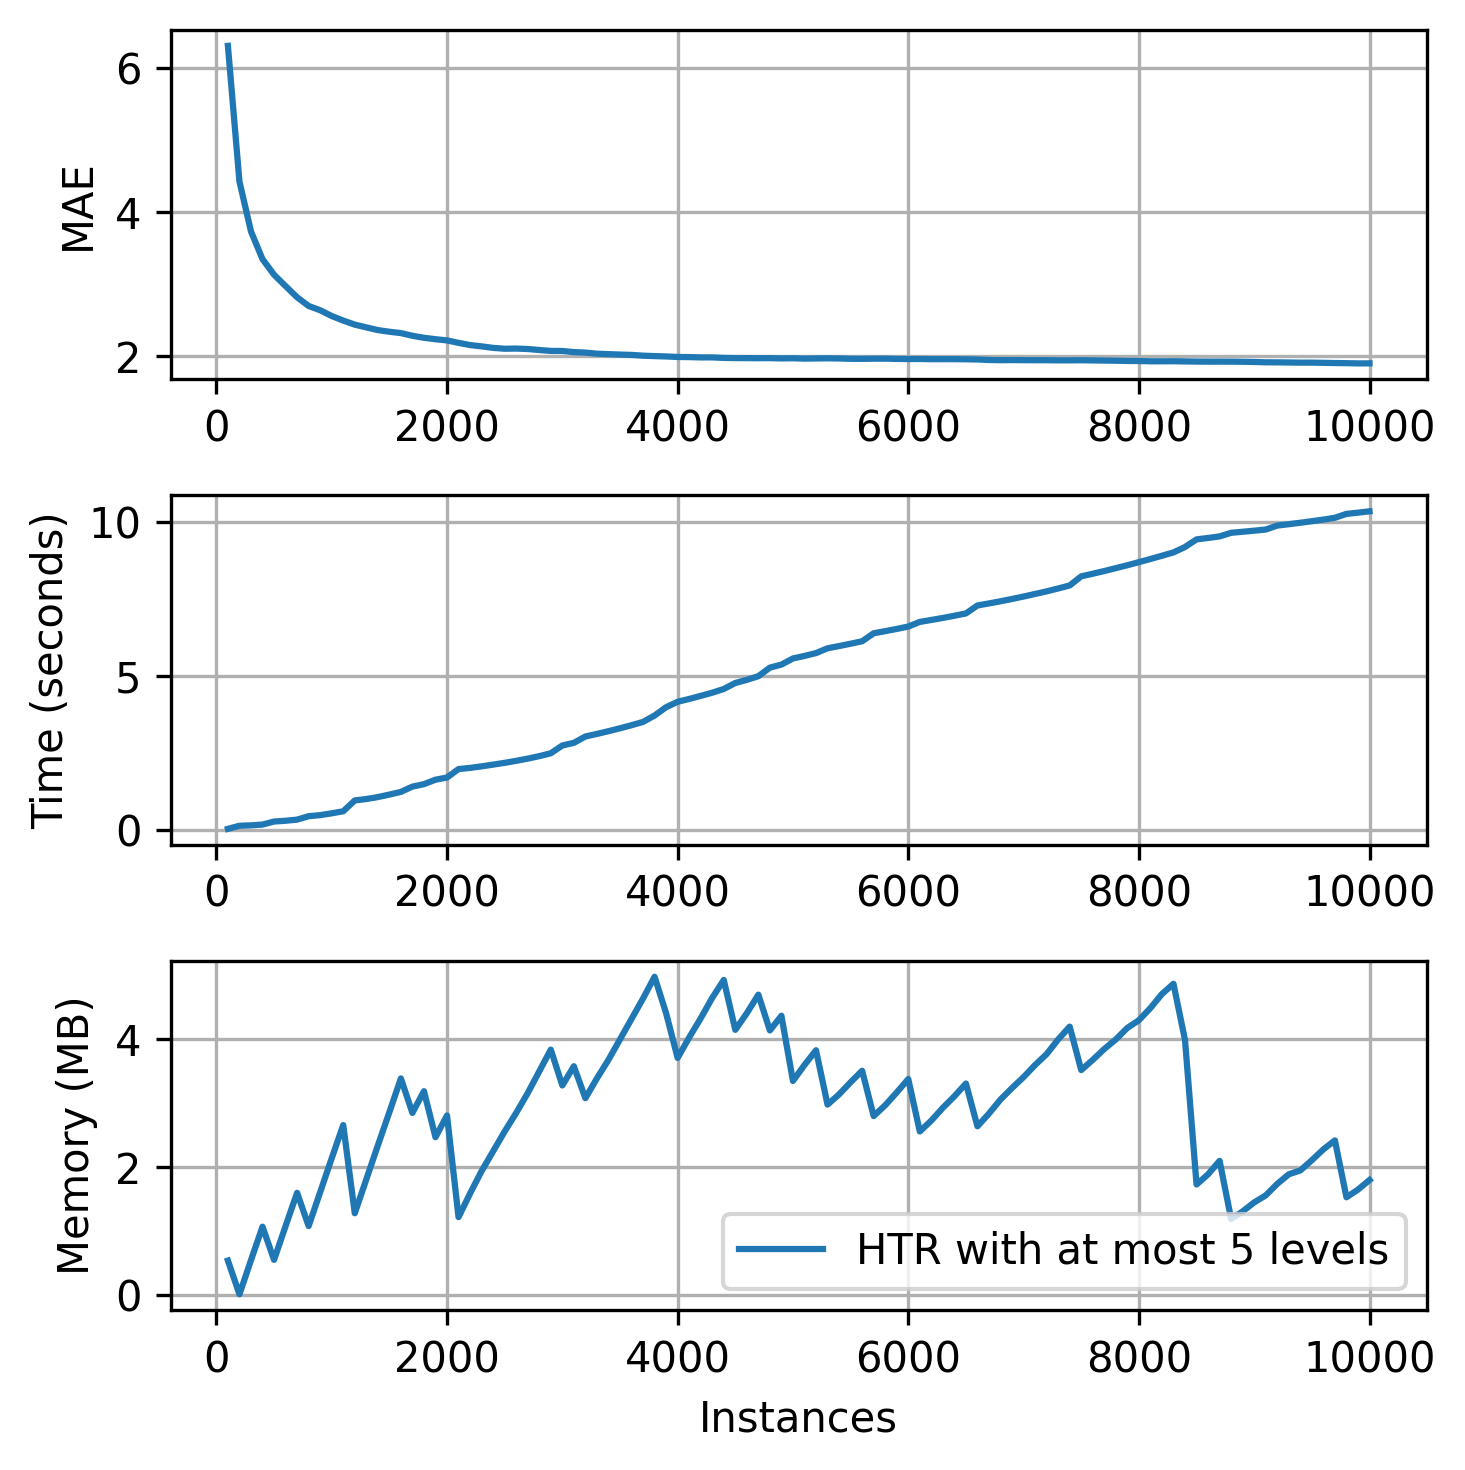

In [48]:
plot_track(
    friedman_track,
    "MAE",
    {
        "HTR with at most 5 levels": (
            preprocessing.StandardScaler()
            | tree.HoeffdingTreeRegressor(max_depth=5)
        )
    },
    10_000,
    100
)

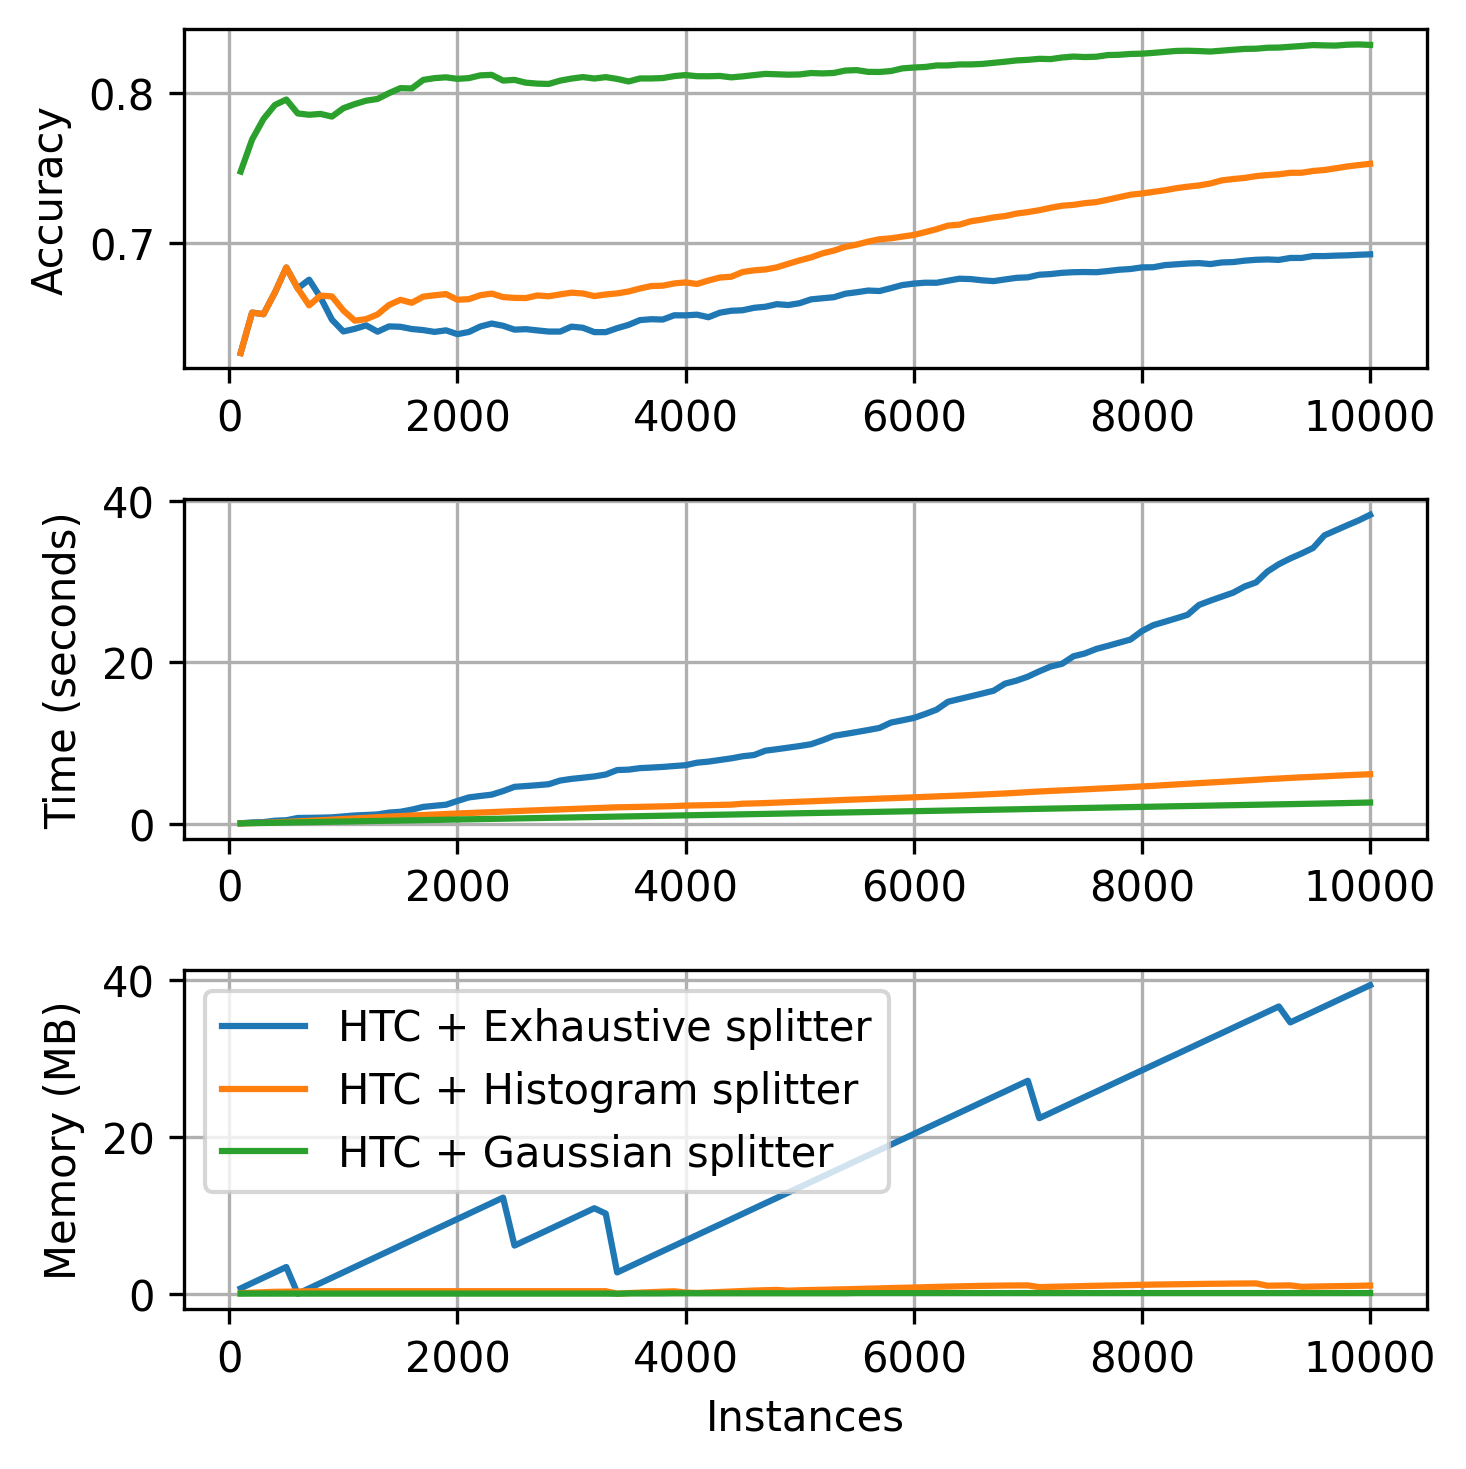

In [49]:
def random_rbf_track(n_samples=10_000):
    dataset = synth.RandomRBF(seed_model=7, seed_sample=42).take(n_samples)
    track = evaluate.Track("10K Random RBF + Accuracy", dataset, metrics.Accuracy(), n_samples)

    return track

plot_track(
    random_rbf_track,
    "Accuracy",
    {
        "HTC + Exhaustive splitter": tree.HoeffdingTreeClassifier(
            splitter=tree.splitter.ExhaustiveSplitter(),
            leaf_prediction="mc"
        ),
        "HTC + Histogram splitter": tree.HoeffdingTreeClassifier(
            splitter=tree.splitter.HistogramSplitter()
        ),
        "HTC + Gaussian splitter": tree.HoeffdingTreeClassifier(
            splitter=tree.splitter.GaussianSplitter()
        )
    },
    10_000,
    100
)

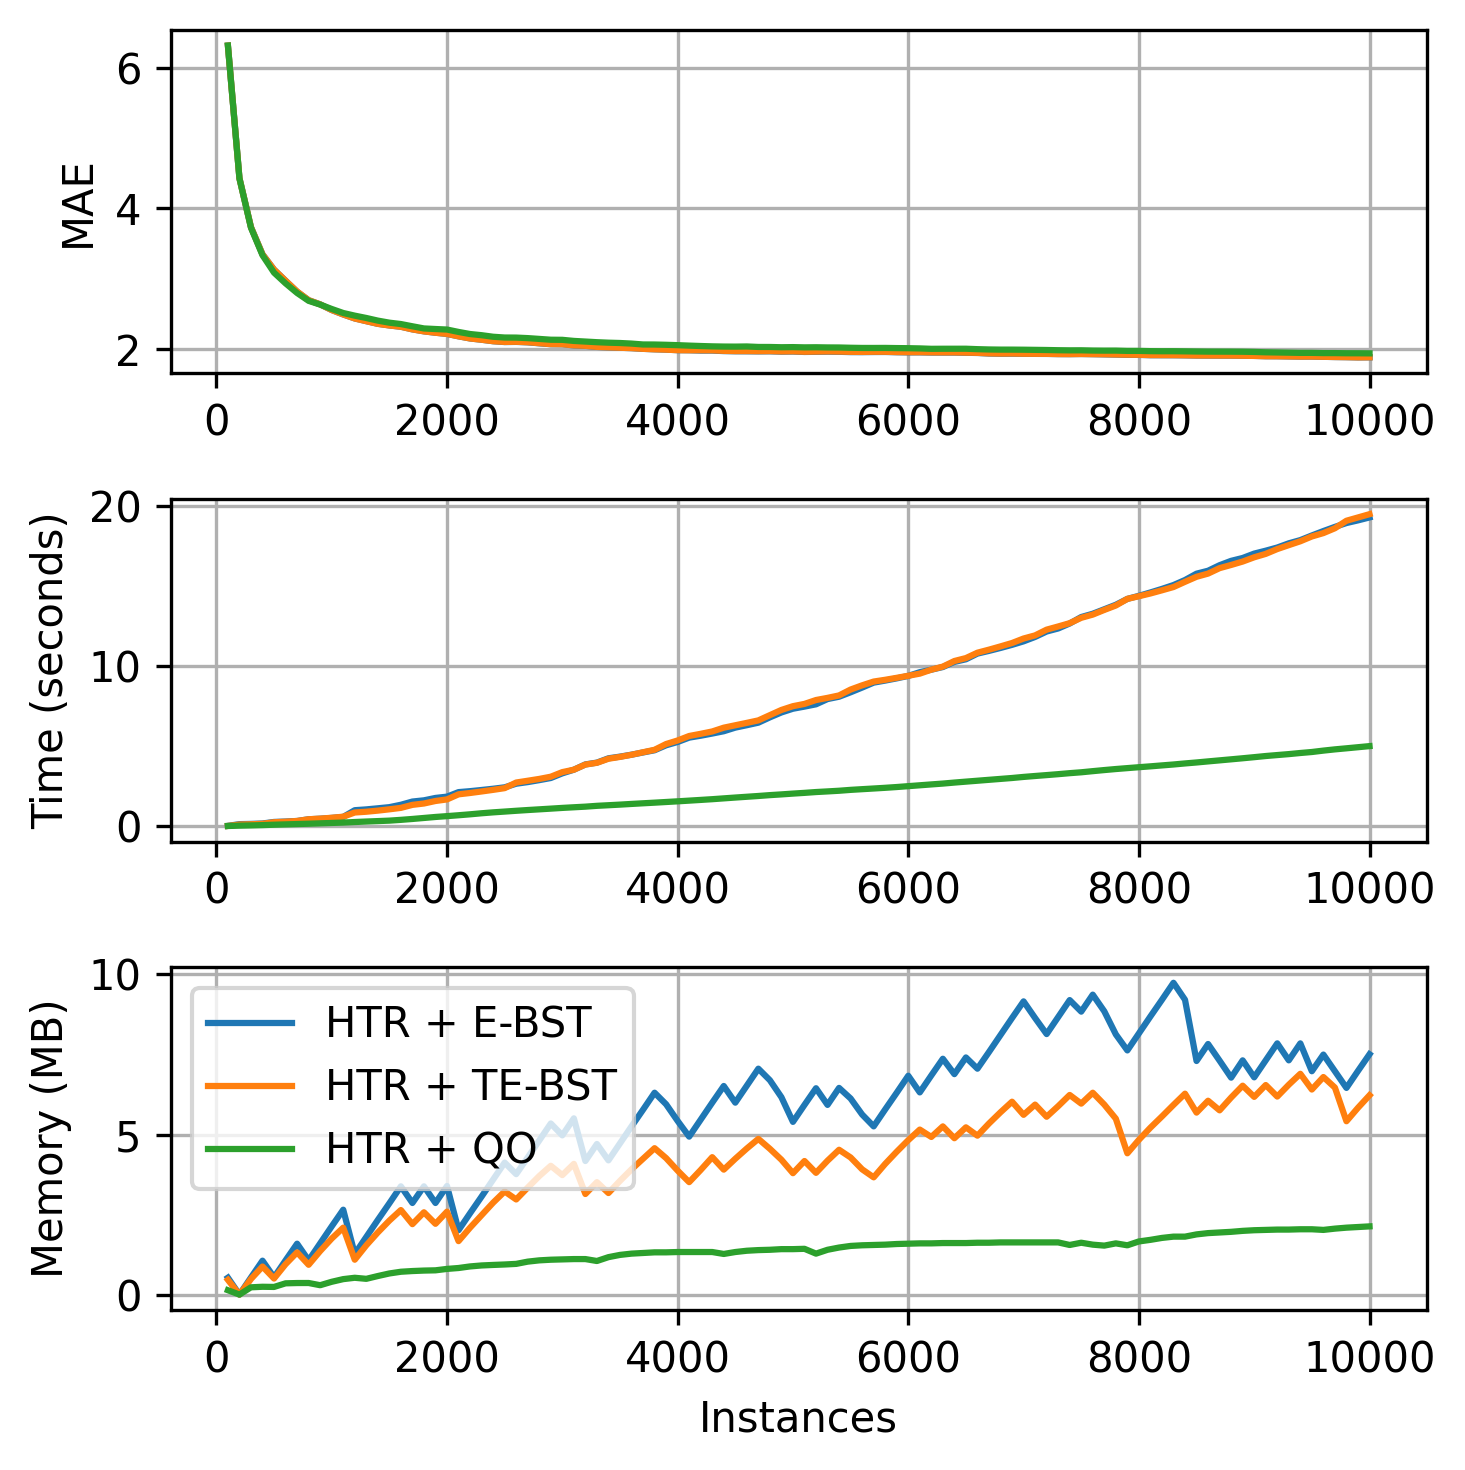

In [50]:
plot_track(
    friedman_track,
    "MAE",
    {
        "HTR + E-BST": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.EBSTSplitter()
            )
        ),
        "HTR + TE-BST": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.TEBSTSplitter(digits=2)
            )
        ),
        "HTR + QO": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),

    },
    10_000,
    100
)